<a href="https://colab.research.google.com/github/karthiksagarN/DeepFake-Detection/blob/main/Predict_deepfake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 17.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566170 sha256=d5ccaa7d6ff2786e5267970d117bcf9cf68d15236f408f138fccc139a9afd68d
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


## PREDICTION

In [3]:
import warnings
warnings.filterwarnings('ignore')
import torch
from torch import nn
from torch.autograd import Variable
import torchvision
from torchvision import models
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import sys
import time
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import face_recognition

In [4]:
#Model with feature visualization
from torch import nn
from torchvision import models
class Model(nn.Module):
    def __init__(self, num_classes=2,latent_dim= 2048, lstm_layers=1 , hidden_dim = 2048, bidirectional = False):
        super(Model, self).__init__()
        model = models.resnext50_32x4d(pretrained = True) #Residual Network CNN
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
    def forward(self, x):
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size,seq_length,2048)
        x_lstm,_ = self.lstm(x,None)
        return fmap,self.dp(self.linear1(torch.mean(x_lstm,dim = 1)))

In [5]:
im_size = 112
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
sm = nn.Softmax()
inv_normalize =  transforms.Normalize(mean=-1*np.divide(mean,std),std=np.divide([1,1,1],std))
def im_convert(tensor):
    """ Display a tensor as an image. """
    image = tensor.to("cpu").clone().detach()
    image = image.squeeze()
    image = inv_normalize(image)
    image = image.numpy()
    image = image.transpose(1,2,0)
    image = image.clip(0, 1)
    cv2.imwrite('./2.png',image*255)
    return image

def predict(model,img,path = './'):
  fmap,logits = model(img.to('cuda'))
  params = list(model.parameters())
  weight_softmax = model.linear1.weight.detach().cpu().numpy()
  logits = sm(logits)
  _,prediction = torch.max(logits,1)
  confidence = logits[:,int(prediction.item())].item()*100
  print('confidence of prediction:',logits[:,int(prediction.item())].item()*100)
  idx = np.argmax(logits.detach().cpu().numpy())
  bz, nc, h, w = fmap.shape
  out = np.dot(fmap[-1].detach().cpu().numpy().reshape((nc, h*w)).T,weight_softmax[idx,:].T)
  predict = out.reshape(h,w)
  predict = predict - np.min(predict)
  predict_img = predict / np.max(predict)
  predict_img = np.uint8(255*predict_img)
  out = cv2.resize(predict_img, (im_size,im_size))
  heatmap = cv2.applyColorMap(out, cv2.COLORMAP_JET)
  img = im_convert(img[:,-1,:,:,:])
  result = heatmap * 0.5 + img*0.8*255
  cv2.imwrite('/content/drive/MyDrive/DeepFake/FF++/HeatMaps/3.png',result)
  result1 = heatmap * 0.5/255 + img*0.8
  r,g,b = cv2.split(result1)
  result1 = cv2.merge((r,g,b))
  plt.imshow(result1)
  plt.show()
  return [int(prediction.item()),confidence]
#img = train_data[100][0].unsqueeze(0)
#predict(model,img)

In [6]:
class validation_dataset(Dataset):
    def __init__(self,video_names,sequence_length = 60,transform = None):
        self.video_names = video_names
        self.transform = transform
        self.count = sequence_length
    def __len__(self):
        return len(self.video_names)
    def __getitem__(self,idx):
        video_path = self.video_names[idx]
        frames = []
        a = int(100/self.count)
        first_frame = np.random.randint(0,a)
        for i,frame in enumerate(self.frame_extract(video_path)):
            #if(i % a == first_frame):
            faces = face_recognition.face_locations(frame)
            try:
              top,right,bottom,left = faces[0]
              frame = frame[top:bottom,left:right,:]
            except:
              pass
            frames.append(self.transform(frame))
            if(len(frames) == self.count):
              break
        #print("no of frames",len(frames))
        frames = torch.stack(frames)
        frames = frames[:self.count]
        return frames.unsqueeze(0)
    def frame_extract(self,path):
      vidObj = cv2.VideoCapture(path)
      success = 1
      while success:
          success, image = vidObj.read()
          if success:
              yield image
def im_plot(tensor):
    image = tensor.cpu().numpy().transpose(1,2,0)
    b,g,r = cv2.split(image)
    image = cv2.merge((r,g,b))
    image = image*[0.22803, 0.22145, 0.216989] +  [0.43216, 0.394666, 0.37645]
    image = image*255.0
    plt.imshow(image.astype(int))
    plt.show()

In [7]:
#Code for making prediction
im_size = 224
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

train_transforms = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

def predict(model_path,path_to_videos):
  path_to_videos= [path_to_videos]

  video_dataset = validation_dataset(path_to_videos,sequence_length = 20,transform = train_transforms)
  model = Model(2).cuda()
  model_path = model_path
  model.load_state_dict(torch.load(model_path))
  model.eval()
  for i in range(0,len(path_to_videos)):
    print(path_to_videos[i])
    prediction = predict(model,video_dataset[i],'./')
    if prediction[0] == 1:
      print("REAL VIDEO")
      return "real"
    else:
      print("DEEP-FAKE VIDEO")
      return "fake"

#### Predictions testing

/content/drive/MyDrive/DeepFake/testing-prediction/rashmika-deepfake.mp4


confidence of prediction: 99.23917651176453


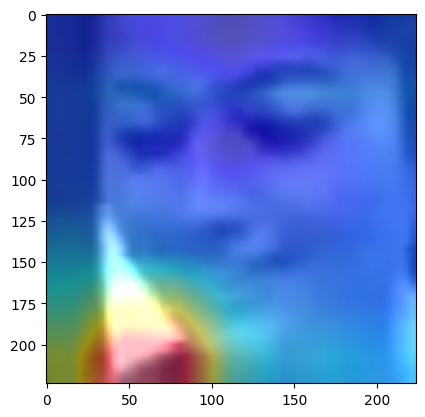

DEEP-FAKE VIDEO


In [ ]:
#Code for making prediction
im_size = 224
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

train_transforms = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

path_to_videos= ["/content/drive/MyDrive/DeepFake/testing-prediction/rashmika-deepfake.mp4"]

video_dataset = validation_dataset(path_to_videos,sequence_length = 20,transform = train_transforms)
model = Model(2).cuda()
path_to_model = '/content/drive/MyDrive/DeepFake/best_model_accuracy.pt'
model.load_state_dict(torch.load(path_to_model))
model.eval()
for i in range(0,len(path_to_videos)):
  print(path_to_videos[i])
  prediction = predict(model,video_dataset[i],'./')
  if prediction[0] == 1:
    print("REAL VIDEO")
  else:
    print("DEEP-FAKE VIDEO")

/content/drive/MyDrive/DeepFake/FF++/facecropped/real/06__talking_against_wall.mp4


confidence of prediction: 68.2169497013092


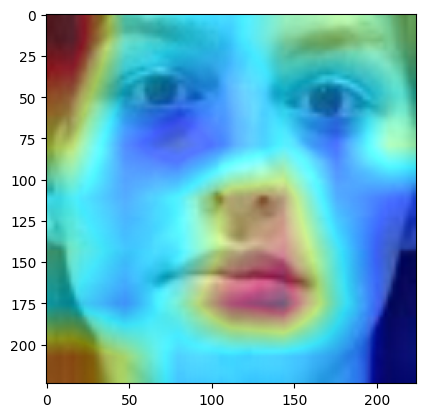

REAL VIDEO


In [ ]:
#Code for making prediction
im_size = 224
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

train_transforms = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

path_to_videos= ["/content/drive/MyDrive/DeepFake/FF++/facecropped/real/06__talking_against_wall.mp4"]

video_dataset = validation_dataset(path_to_videos,sequence_length = 20,transform = train_transforms)
model = Model(2).cuda()
path_to_model = '/content/drive/MyDrive/DeepFake/best_model_accuracy.pt'
model.load_state_dict(torch.load(path_to_model))
model.eval()
for i in range(0,len(path_to_videos)):
  print(path_to_videos[i])
  prediction = predict(model,video_dataset[i],'./')
  if prediction[0] == 1:
    print("REAL VIDEO")
  else:
    print("DEEP-FAKE VIDEO")

# STREAMLIT CODE


###Ip-Address-Tunnel Password = 34.125.148.168

### requirements to run streamlit app in colab

In [8]:
! pip install streamlit -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 65.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.6 MB/s eta 0:00:00


In [9]:
!wget -q -O - ipv4.icanhazip.com

34.125.148.168


### App Code which just displays real or fake as text and confidence as number

In [29]:
%%writefile main.py
import streamlit as st
import torch
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import numpy as np
import cv2
import face_recognition
from torch.autograd import Variable
import time
import sys
from torch import nn
import json
import glob
import copy
from PIL import Image as pImage
import shutil
import os

im_size = 112
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
sm = nn.Softmax()
inv_normalize = transforms.Normalize(mean=-1*np.divide(mean,std),std=np.divide([1,1,1],std))

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((im_size,im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)])

class Model(nn.Module):
    def __init__(self, num_classes,latent_dim= 2048, lstm_layers=1 , hidden_dim = 2048, bidirectional = False):
        super(Model, self).__init__()
        model = models.resnext50_32x4d(pretrained=True)
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size,seq_length,2048)
        x_lstm,_ = self.lstm(x,None)
        return fmap,self.dp(self.linear1(x_lstm[:,-1,:]))

class validation_dataset(Dataset):
    def __init__(self,video_names,sequence_length=60,transform=None):
        self.video_names = video_names
        self.transform = transform
        self.count = sequence_length

    def __len__(self):
        return len(self.video_names)

    def __getitem__(self,idx):
        video_path = self.video_names[idx]
        frames = []
        a = int(100/self.count)
        first_frame = np.random.randint(0,a)
        for i,frame in enumerate(self.frame_extract(video_path)):
            faces = face_recognition.face_locations(frame)
            try:
                top,right,bottom,left = faces[0]
                frame = frame[top:bottom,left:right,:]
            except:
                pass
            frames.append(self.transform(frame))
            if(len(frames) == self.count):
                break
        frames = torch.stack(frames)
        frames = frames[:self.count]
        return frames.unsqueeze(0)

    def frame_extract(self,path):
        vidObj = cv2.VideoCapture(path)
        success = 1
        while success:
            success, image = vidObj.read()
            if success:
                yield image

def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.squeeze()
    image = inv_normalize(image)
    image = image.numpy()
    image = image.transpose(1,2,0)
    image = image.clip(0, 1)
    return image

def predict(model,img):
    fmap,logits = model(img.to('cuda'))
    logits = sm(logits)
    _,prediction = torch.max(logits,1)
    confidence = logits[:,int(prediction.item())].item()*100
    return [int(prediction.item()), confidence]

def save_uploaded_file(uploaded_file, save_dir):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    file_path = os.path.join(save_dir, uploaded_file.name)
    with open(file_path, "wb") as f:
        f.write(uploaded_file.getbuffer())
    return file_path

def index():
    st.title("DeepFake Video Detection")
    uploaded_file = st.file_uploader("Upload a video", type=["mp4", "gif", "webm", "avi", "3gp", "wmv", "flv", "mkv"])

    if uploaded_file is not None:

        # Display the uploaded video
        st.video(uploaded_file)

        sequence_length = st.number_input("Enter sequence length", min_value=1, value=60)
        model = Model(2).cuda()
        st.write("Model loaded successfully.")
        st.write("Starting prediction...")

        # Save the uploaded file to disk
        video_path = save_uploaded_file(uploaded_file, "uploaded_videos")

        video_dataset = validation_dataset([video_path], sequence_length=sequence_length, transform=train_transforms)

        # Load the trained model
        path_to_model = "/content/drive/MyDrive/DeepFake/best_model_accuracy.pt"
        model.load_state_dict(torch.load(path_to_model))
        model.eval()
        prediction = predict(model, video_dataset[0])

        # Display prediction with icons or emojis
        prediction_text = "REAL" if prediction[0] == 1 else "FAKE"
        prediction_icon = "✅" if prediction[0] == 1 else "❌"
        st.write(f"Prediction: {prediction_text} {prediction_icon}")

        st.write("Confidence:", round(prediction[1], 2))

if __name__ == "__main__":
    index()



Overwriting main.py


In [30]:
!streamlit run main.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.125.148.168:8501

npx: installed 22 in 1.793s
your url is: https://early-bushes-trade.loca.lt
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. 

### App code which displays the resulting video with box and predictions

In [38]:
%%writefile app.py
import streamlit as st
import torch
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import numpy as np
import cv2
import face_recognition
from torch.autograd import Variable
import time
import sys
from torch import nn
import json
import glob
import copy
from PIL import Image as pImage
import shutil
import os

im_size = 112
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
sm = nn.Softmax()
inv_normalize = transforms.Normalize(mean=-1*np.divide(mean,std),std=np.divide([1,1,1],std))

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((im_size,im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)])

class Model(nn.Module):
    def __init__(self, num_classes,latent_dim= 2048, lstm_layers=1 , hidden_dim = 2048, bidirectional = False):
        super(Model, self).__init__()
        model = models.resnext50_32x4d(pretrained=True)
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size,seq_length,2048)
        x_lstm,_ = self.lstm(x,None)
        return fmap,self.dp(self.linear1(x_lstm[:,-1,:]))

class validation_dataset(Dataset):
    def __init__(self,video_names,sequence_length=60,transform=None):
        self.video_names = video_names
        self.transform = transform
        self.count = sequence_length

    def __len__(self):
        return len(self.video_names)

    def __getitem__(self,idx):
        video_path = self.video_names[idx]
        frames = []
        a = int(100/self.count)
        first_frame = np.random.randint(0,a)
        for i,frame in enumerate(self.frame_extract(video_path)):
            faces = face_recognition.face_locations(frame)
            try:
                top,right,bottom,left = faces[0]
                frame = frame[top:bottom,left:right,:]
            except:
                pass
            frames.append(self.transform(frame))
            if(len(frames) == self.count):
                break
        frames = torch.stack(frames)
        frames = frames[:self.count]
        return frames.unsqueeze(0)

    def frame_extract(self,path):
        vidObj = cv2.VideoCapture(path)
        success = 1
        while success:
            success, image = vidObj.read()
            if success:
                yield image

def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.squeeze()
    image = inv_normalize(image)
    image = image.numpy()
    image = image.transpose(1,2,0)
    image = image.clip(0, 1)
    return image

def predict(model,img):
    fmap,logits = model(img.to('cuda'))
    logits = sm(logits)
    _,prediction = torch.max(logits,1)
    confidence = logits[:,int(prediction.item())].item()*100
    return [int(prediction.item()), confidence]

def save_uploaded_file(uploaded_file, save_dir):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    file_path = os.path.join(save_dir, uploaded_file.name)
    with open(file_path, "wb") as f:
        f.write(uploaded_file.getbuffer())
    return file_path

def run_model():
    st.title("DeepFake Video Detection")
    uploaded_file = st.file_uploader("Upload a video", type=["mp4", "gif", "webm", "avi", "3gp", "wmv", "flv", "mkv"])
    if uploaded_file is not None:
        # Display the uploaded video
        st.video(uploaded_file)

        # Wait for the user to input sequence length
        sequence_length = st.number_input("Enter sequence length", min_value=1, value=60)

        # Check if the user has entered sequence length
        if sequence_length:
            model = Model(2).cuda()
            st.write("Model loaded successfully.")
            st.write("Starting prediction...")

            # Save the uploaded file to disk
            video_path = save_uploaded_file(uploaded_file, "uploaded_videos")

            video_dataset = validation_dataset([video_path], sequence_length=sequence_length, transform=train_transforms)
            path_to_model = "/content/drive/MyDrive/DeepFake/best_model_accuracy.pt"
            model.load_state_dict(torch.load(path_to_model))
            model.eval()
            prediction = predict(model, video_dataset[0])

            # Display prediction with icons or emojis
            prediction_text = "REAL" if prediction[0] == 1 else "FAKE"
            prediction_icon = "✅" if prediction[0] == 1 else "❌"
            st.write(f"Prediction: {prediction_text} {prediction_icon}")

            st.write("Confidence:", round(prediction[1], 2))

            # Load the video using OpenCV
            cap = cv2.VideoCapture(video_path)

            # Get video properties
            width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            fps = int(cap.get(cv2.CAP_PROP_FPS))

            # Define the codec and create VideoWriter object
            out = cv2.VideoWriter('output.avi', cv2.VideoWriter_fourcc('M','J','P','G'), fps, (width, height))

            # Process each frame of the video
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break

                # Detect faces in the frame
                face_locations = face_recognition.face_locations(frame)

                # Overlay prediction text on each face
                for top, right, bottom, left in face_locations:
                    cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 2)
                    cv2.putText(frame, f"{prediction_text} {prediction_icon}", (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

                # Write the frame to the output video
                out.write(frame)

            # Release the video capture and writer objects
            cap.release()
            out.release()

            # Display the processed video
            st.video('output.avi')

if __name__ == "__main__":
    run_model()


Overwriting app.py


In [39]:
!streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.125.148.168:8501

npx: installed 22 in 1.729s
your url is: https://dark-turkeys-make.loca.lt
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. C

### App code which displayed frames as resulting images with predictions

In [41]:
%%writefile app.py
import streamlit as st
import torch
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import numpy as np
import cv2
import face_recognition
from torch.autograd import Variable
import time
import sys
from torch import nn
import json
import glob
import copy
from PIL import Image as pImage
import shutil
import os

im_size = 112
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
sm = nn.Softmax()
inv_normalize = transforms.Normalize(mean=-1*np.divide(mean,std),std=np.divide([1,1,1],std))

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((im_size,im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)])

class Model(nn.Module):
    def __init__(self, num_classes,latent_dim= 2048, lstm_layers=1 , hidden_dim = 2048, bidirectional = False):
        super(Model, self).__init__()
        model = models.resnext50_32x4d(pretrained=True)
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size,seq_length,2048)
        x_lstm,_ = self.lstm(x,None)
        return fmap,self.dp(self.linear1(x_lstm[:,-1,:]))

class validation_dataset(Dataset):
    def __init__(self,video_names,sequence_length=60,transform=None):
        self.video_names = video_names
        self.transform = transform
        self.count = sequence_length

    def __len__(self):
        return len(self.video_names)

    def __getitem__(self,idx):
        video_path = self.video_names[idx]
        frames = []
        a = int(100/self.count)
        first_frame = np.random.randint(0,a)
        for i,frame in enumerate(self.frame_extract(video_path)):
            faces = face_recognition.face_locations(frame)
            try:
                top,right,bottom,left = faces[0]
                frame = frame[top:bottom,left:right,:]
            except:
                pass
            frames.append(self.transform(frame))
            if(len(frames) == self.count):
                break
        frames = torch.stack(frames)
        frames = frames[:self.count]
        return frames.unsqueeze(0)

    def frame_extract(self,path):
        vidObj = cv2.VideoCapture(path)
        success = 1
        while success:
            success, image = vidObj.read()
            if success:
                yield image

def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.squeeze()
    image = inv_normalize(image)
    image = image.numpy()
    image = image.transpose(1,2,0)
    image = image.clip(0, 1)
    return image

def predict(model,img):
    fmap,logits = model(img.to('cuda'))
    logits = sm(logits)
    _,prediction = torch.max(logits,1)
    confidence = logits[:,int(prediction.item())].item()*100
    return [int(prediction.item()), confidence]

def save_uploaded_file(uploaded_file, save_dir):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    file_path = os.path.join(save_dir, uploaded_file.name)
    with open(file_path, "wb") as f:
        f.write(uploaded_file.getbuffer())
    return file_path

def index():
    st.title("DeepFake Video Detection")
    uploaded_file = st.file_uploader("Upload a video", type=["mp4", "gif", "webm", "avi", "3gp", "wmv", "flv", "mkv"])

    if uploaded_file is not None:

        # Display the uploaded video
        st.video(uploaded_file)

        sequence_length = st.number_input("Enter sequence length", min_value=1, value=60)
        model = Model(2).cuda()
        st.write("Model loaded successfully.")
        st.write("Starting prediction...")

        # Save the uploaded file to disk
        video_path = save_uploaded_file(uploaded_file, "uploaded_videos")

        video_dataset = validation_dataset([video_path], sequence_length=sequence_length, transform=train_transforms)

        # Load the trained model
        path_to_model = "/content/drive/MyDrive/DeepFake/best_model_accuracy.pt"
        model.load_state_dict(torch.load(path_to_model))
        model.eval()
        prediction = predict(model, video_dataset[0])

        # Display prediction with icons or emojis
        prediction_text = "REAL" if prediction[0] == 1 else "FAKE"
        prediction_icon = "✅" if prediction[0] == 1 else "❌"
        st.write(f"Prediction: {prediction_text} {prediction_icon}")

        st.write("Confidence:", round(prediction[1], 2))

        # Load the video using OpenCV
        cap = cv2.VideoCapture(video_path)

        # Process each frame of the video
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Detect faces in the frame
            face_locations = face_recognition.face_locations(frame)

            # Overlay prediction text on each face
            for top, right, bottom, left in face_locations:
                cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 2)
                prediction = predict(model, video_dataset[0])
                prediction_text = "REAL" if prediction[0] == 1 else "FAKE"
                prediction_confidence = round(prediction[1], 2)
                cv2.putText(frame, f"Prediction: {prediction_text} Confidence: {prediction_confidence}", (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

            # Convert the frame to RGB and display using Streamlit
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            st.image(frame_rgb, channels="RGB")

        # Release the video capture object
        cap.release()

if __name__ == "__main__":
    index()

Overwriting app.py


Ip-Address-Tunnel Password = 34.125.148.168

In [42]:
!streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.125.148.168:8501

npx: installed 22 in 1.805s
your url is: https://sharp-pumas-find.loca.lt
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Ch